In [1]:
import pandas as pd
import supporter
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
import joblib
import random
import seaborn as sns

random.seed(7)

#Porcentaje de los datos de entrenamiento
train_size=0.8
#Porcentaje de los datos de Test
test_size=0.2

#Parrilla de hiper-parámetros para GridSearchCV
parameter_space = {
    '_optimizer': ['SGD', 'Adam'],
    '_init_mode': ['glorot_uniform', 'normal', 'uniform'],
    'epochs': [10, 20, 50, 100, 200],
    'batch_size' : [10, 20, 50, 100],
    '_filters': [8, 16, 32, 64],
    '_kernel_size': [1, 2, 4, 8],
}

#Validación cruzada para series temporales
cv = TimeSeriesSplit(n_splits = 10)

In [2]:
def create_CNN_model(_optimizer='adam', _init_mode='uniform', _filters=64, _kernel_size=2):
    model = Sequential()
    model.add(Conv1D(filters=_filters, kernel_size=_kernel_size, kernel_initializer=_init_mode,
                     activation='relu', input_shape=(n_predictors, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, kernel_initializer=_init_mode, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=_optimizer, loss='mse')
    return model

#Encapsulamos el modelo keras para que sea compatatible con las funciones SkLearn
model_CNN = KerasRegressor(build_fn=create_CNN_model, verbose=0)

# 7 días sin información diaria

In [3]:
df_7d_no_info = pd.read_csv(r'./consumo_diario_03_7d_no_info.csv',parse_dates=["Fecha"], index_col=["Fecha"])

In [4]:
X_train_7d_no_info, X_test_7d_no_info, y_train_7d_no_info, y_test_7d_no_info = supporter.split_train_test_deep(df_7d_no_info,
                                                train_size_=train_size,test_size_=test_size,
                                                target="Consumo(t)", _scale=True,verbose=False)

n_predictors = X_train_7d_no_info.shape[1]
n_features = 1

In [ ]:
grid = GridSearchCV(estimator=model_CNN, param_grid=parameter_space, n_jobs=-1, cv=cv)

grid_result = grid.fit(X_train_7d_no_info, y_train_7d_no_info)

best_conf = grid_result.best_params_
joblib.dump(best_conf, 'CNN_7d_no_info_normalizado_best_conf.pkl')

best_estimator = grid_result.best_estimator_
_7d_no_info_RMSE, _7d_no_info_MAE, _7d_no_info_MAPE = supporter.crear_tabla_errores_cv_train(best_estimator,
                                                                                             X_train_7d_no_info,
                                                                                             y_train_7d_no_info,
                                                                                             cv,
                                                                                             '7 días sin información diaria')
joblib.dump(_7d_no_info_RMSE, 'CNN_7d_no_info_normalizado_RMSE_training.pkl')
joblib.dump(_7d_no_info_MAE, 'CNN_7d_no_info_normalizado_MAE_training.pkl')
joblib.dump(_7d_no_info_MAPE, 'CNN_7d_no_info_normalizado_MAPE_training.pkl')

predictor = best_estimator.model
predictor.save('CNN_7d_no_info_normalizado_best_model.h5')

In [5]:
best_conf = joblib.load('CNN_7d_no_info_normalizado_best_conf.pkl')
best_conf

{'_filters': 64,
 '_init_mode': 'glorot_uniform',
 '_kernel_size': 4,
 '_optimizer': 'Adam',
 'batch_size': 100,
 'epochs': 200}

In [6]:
_7d_no_info_RMSE = joblib.load('CNN_7d_no_info_normalizado_RMSE_training.pkl')
_7d_no_info_MAE = joblib.load('CNN_7d_no_info_normalizado_MAE_training.pkl')
_7d_no_info_MAPE = joblib.load('CNN_7d_no_info_normalizado_MAPE_training.pkl')

In [7]:
predictor_7d_no_info = load_model('CNN_7d_no_info_normalizado_best_model.h5')

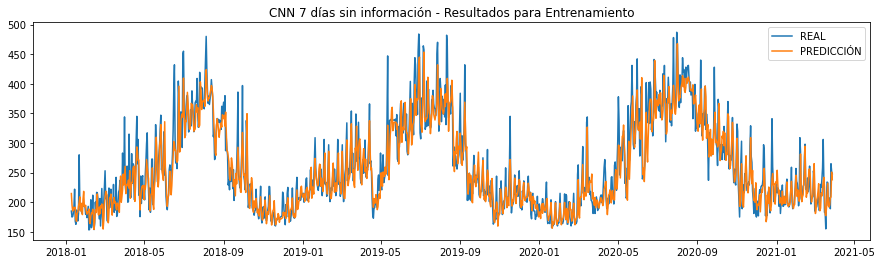

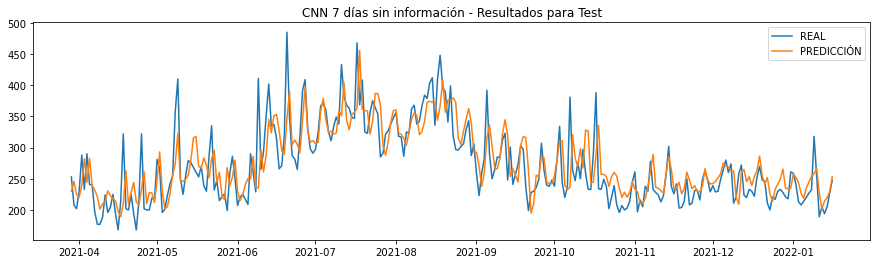

In [8]:
supporter.grafica_resultado(predictor_7d_no_info,"CNN 7 días sin información", df_7d_no_info,
                            train_size,test_size,show_scaled=False)

In [9]:
supporter.regression_results(y_test_7d_no_info, predictor_7d_no_info.predict(X_test_7d_no_info))

r2:  0.63
MAE:  0.08
MSE:  0.01
RMSE:  0.11
MAPE (%):  22.71


# 7 días con información diaria

In [10]:
df_7d_info = pd.read_csv(r'./consumo_diario_03_7d_info.csv',parse_dates=["Fecha"], index_col=["Fecha"])

In [11]:
X_train_7d_info, X_test_7d_info, y_train_7d_info, y_test_7d_info = supporter.split_train_test_deep(df_7d_info,
                                                train_size_=train_size,test_size_=test_size,
                                                target="Consumo(t)", _scale=True,verbose=False)

n_predictors = X_train_7d_info.shape[1]
n_features = 1

In [ ]:
grid = GridSearchCV(estimator=model_CNN, param_grid=parameter_space, n_jobs=-1, cv=cv)

grid_result = grid.fit(X_train_7d_info, y_train_7d_info)

best_conf = grid_result.best_params_
joblib.dump(best_conf, 'CNN_7d_info_normalizado_best_conf.pkl')

best_estimator = grid_result.best_estimator_
_7d_info_RMSE, _7d_info_MAE, _7d_info_MAPE = supporter.crear_tabla_errores_cv_train(best_estimator,
                                                                                         X_train_7d_info,
                                                                                         y_train_7d_info,
                                                                                         cv,
                                                                                         '7 días con información diaria')
joblib.dump(_7d_info_RMSE, 'CNN_7d_info_normalizado_RMSE_training.pkl')
joblib.dump(_7d_info_MAE, 'CNN_7d_info_normalizado_MAE_training.pkl')
joblib.dump(_7d_info_MAPE, 'CNN_7d_info_normalizado_MAPE_training.pkl')

predictor = best_estimator.model
predictor.save('CNN_7d_info_normalizado_best_model.h5')

In [12]:
best_conf = joblib.load('CNN_7d_info_normalizado_best_conf.pkl')
best_conf

{'_filters': 64,
 '_init_mode': 'uniform',
 '_kernel_size': 4,
 '_optimizer': 'Adam',
 'batch_size': 100,
 'epochs': 200}

In [13]:
_7d_info_RMSE = joblib.load('CNN_7d_info_normalizado_RMSE_training.pkl')
_7d_info_MAE = joblib.load('CNN_7d_info_normalizado_MAE_training.pkl')
_7d_info_MAPE = joblib.load('CNN_7d_info_normalizado_MAPE_training.pkl')

In [14]:
predictor_7d_info = load_model('CNN_7d_info_normalizado_best_model.h5')

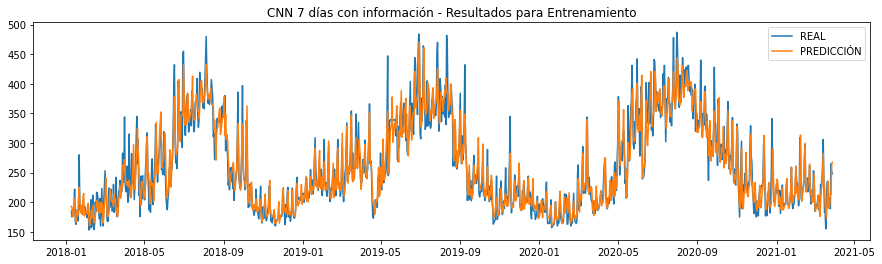

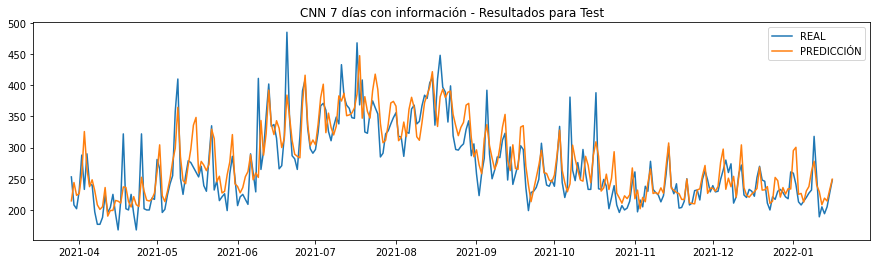

In [15]:
supporter.grafica_resultado(predictor_7d_info,"CNN 7 días con información", df_7d_info,
                            train_size,test_size,show_scaled=False)

In [16]:
supporter.regression_results(y_test_7d_info, predictor_7d_info.predict(X_test_7d_info))

r2:  0.73
MAE:  0.07
MSE:  0.01
RMSE:  0.1
MAPE (%):  19.33


# 14 días sin información diaria

In [17]:
df_14d_no_info = pd.read_csv(r'./consumo_diario_03_14d_no_info.csv',parse_dates=["Fecha"], index_col=["Fecha"])

In [18]:
X_train_14d_no_info, X_test_14d_no_info, y_train_14d_no_info, y_test_14d_no_info = supporter.split_train_test_deep(df_14d_no_info,
                                                train_size_=train_size,test_size_=test_size,
                                                target="Consumo(t)", _scale=True,verbose=False)

n_predictors = X_train_14d_no_info.shape[1]
n_features = 1

In [ ]:
grid = GridSearchCV(estimator=model_CNN, param_grid=parameter_space, n_jobs=-1, cv=cv)

grid_result = grid.fit(X_train_14d_no_info, y_train_14d_no_info)

best_conf = grid_result.best_params_
joblib.dump(best_conf, 'CNN_14d_no_info_normalizado_best_conf.pkl')

best_estimator = grid_result.best_estimator_
_14d_no_info_RMSE, _14d_no_info_MAE, _14d_no_info_MAPE = supporter.crear_tabla_errores_cv_train(best_estimator,
                                                                                                X_train_14d_no_info,
                                                                                                y_train_14d_no_info,
                                                                                                cv,
                                                                                            '14 días sin información diaria')
joblib.dump(_14d_no_info_RMSE, 'CNN_14d_no_info_normalizado_RMSE_training.pkl')
joblib.dump(_14d_no_info_MAE, 'CNN_14d_no_info_normalizado_MAE_training.pkl')
joblib.dump(_14d_no_info_MAPE, 'CNN_14d_no_info_normalizado_MAPE_training.pkl')

predictor = best_estimator.model
predictor.save('CNN_14d_no_info_normalizado_best_model.h5')

In [19]:
best_conf = joblib.load('CNN_14d_no_info_normalizado_best_conf.pkl')
best_conf

{'_filters': 8,
 '_init_mode': 'glorot_uniform',
 '_kernel_size': 1,
 '_optimizer': 'Adam',
 'batch_size': 100,
 'epochs': 200}

In [20]:
_14d_no_info_RMSE = joblib.load('CNN_14d_no_info_normalizado_RMSE_training.pkl')
_14d_no_info_MAE = joblib.load('CNN_14d_no_info_normalizado_MAE_training.pkl')
_14d_no_info_MAPE = joblib.load('CNN_14d_no_info_normalizado_MAPE_training.pkl')

In [21]:
predictor_14d_no_info = load_model('CNN_14d_no_info_normalizado_best_model.h5')

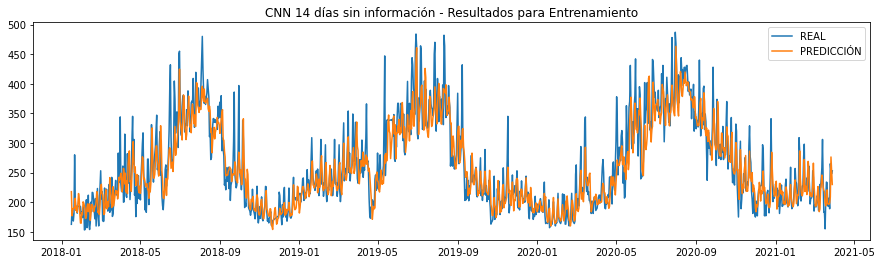

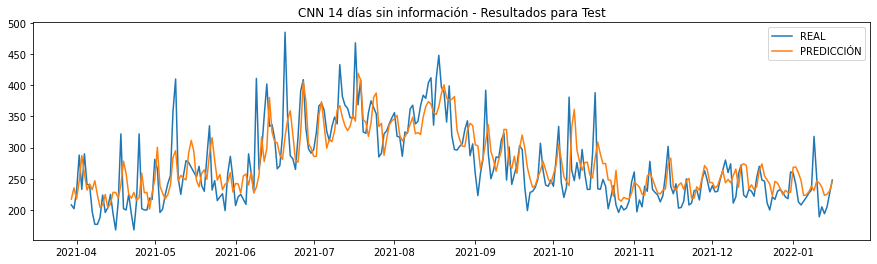

In [22]:
supporter.grafica_resultado(predictor_14d_no_info,"CNN 14 días sin información", df_14d_no_info,
                            train_size,test_size,show_scaled=False)

In [23]:
supporter.regression_results(y_test_14d_no_info, predictor_14d_no_info.predict(X_test_14d_no_info))

r2:  0.59
MAE:  0.09
MSE:  0.01
RMSE:  0.12
MAPE (%):  24.29


# 14 días con información diaria

In [24]:
df_14d_info = pd.read_csv(r'./consumo_diario_03_14d_info.csv',parse_dates=["Fecha"], index_col=["Fecha"])

In [25]:
X_train_14d_info, X_test_14d_info, y_train_14d_info, y_test_14d_info = supporter.split_train_test_deep(df_14d_info,
                                                train_size_=train_size,test_size_=test_size,
                                                target="Consumo(t)", _scale=True,verbose=False)

n_predictors = X_train_14d_info.shape[1]
n_features = 1

In [ ]:
grid = GridSearchCV(estimator=model_CNN, param_grid=parameter_space, n_jobs=-1, cv=cv)

grid_result = grid.fit(X_train_14d_info, y_train_14d_info)

best_conf = grid_result.best_params_
joblib.dump(best_conf, 'CNN_14d_info_normalizado_best_conf.pkl')

best_estimator = grid_result.best_estimator_
_14d_info_RMSE, _14d_info_MAE, _14d_info_MAPE = supporter.crear_tabla_errores_cv_train(best_estimator,
                                                                                       X_train_14d_info,
                                                                                       y_train_14d_info,
                                                                                       cv,
                                                                                       '14 días con información diaria')
joblib.dump(_14d_info_RMSE, 'CNN_14d_info_normalizado_RMSE_training.pkl')
joblib.dump(_14d_info_MAE, 'CNN_14d_info_normalizado_MAE_training.pkl')
joblib.dump(_14d_info_MAPE, 'CNN_14d_info_normalizado_MAPE_training.pkl')

predictor = best_estimator.model
predictor.save('CNN_14d_info_normalizado_best_model.h5')

In [26]:
best_conf = joblib.load('CNN_14d_info_normalizado_best_conf.pkl')
best_conf

{'_filters': 32,
 '_init_mode': 'uniform',
 '_kernel_size': 2,
 '_optimizer': 'Adam',
 'batch_size': 50,
 'epochs': 100}

In [27]:
_14d_info_RMSE = joblib.load('CNN_14d_info_normalizado_RMSE_training.pkl')
_14d_info_MAE = joblib.load('CNN_14d_info_normalizado_MAE_training.pkl')
_14d_info_MAPE = joblib.load('CNN_14d_info_normalizado_MAPE_training.pkl')

In [28]:
predictor_14d_info = load_model('CNN_14d_info_normalizado_best_model.h5')

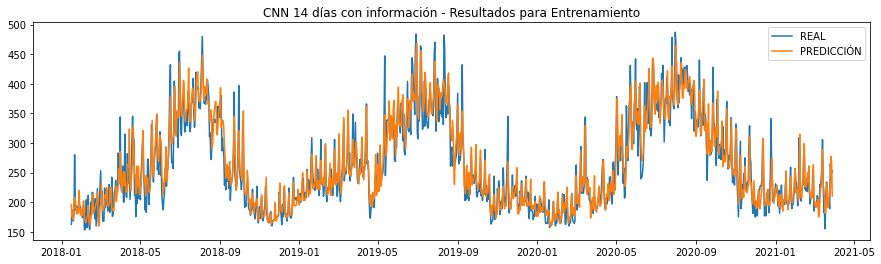

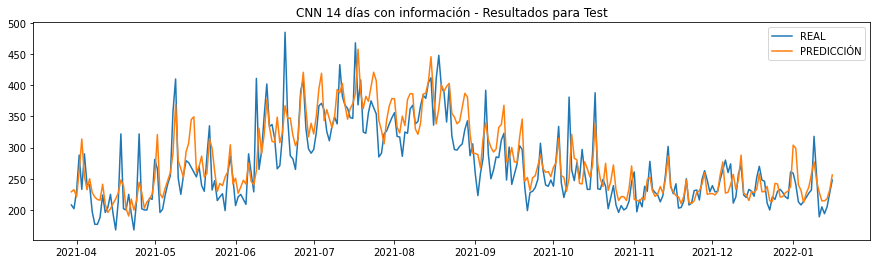

In [29]:
supporter.grafica_resultado(predictor_14d_info,"CNN 14 días con información", df_14d_info,
                            train_size,test_size,show_scaled=False)

In [30]:
supporter.regression_results(y_test_14d_info, predictor_14d_info.predict(X_test_14d_info))

r2:  0.71
MAE:  0.07
MSE:  0.01
RMSE:  0.1
MAPE (%):  20.6


# Juntamos todos los errores de entrenamiento

#### RMSE

In [31]:
errores_training_rmse = pd.concat([_7d_no_info_RMSE, _7d_info_RMSE, _14d_no_info_RMSE, _14d_info_RMSE], axis=1)
errores_training_rmse

,7 días sin información diaria,7 días con información diaria,14 días sin información diaria,14 días con información diaria
Pliegues,,,,
Pliegue 1,0.125461,0.146774,0.160227,0.129571
Pliegue 2,0.102432,0.128911,0.105006,0.127200
Pliegue 3,0.068416,0.077776,0.069975,0.085572
Pliegue 4,0.125108,0.106171,0.134609,0.107773
Pliegue 5,0.108748,0.100358,0.118003,0.104308
Pliegue 6,0.059099,0.055932,0.067572,0.055108
Pliegue 7,0.081111,0.070451,0.095810,0.068435
Pliegue 8,0.119484,0.092561,0.127758,0.101610
Pliegue 9,0.113783,0.097134,0.106484,0.084493


In [32]:
errores_training_rmse.to_csv("./CNN_rmse_training.csv")

[Text(0.5, 0, 'Dataset utilizado'), Text(0, 0.5, 'RMSE')]

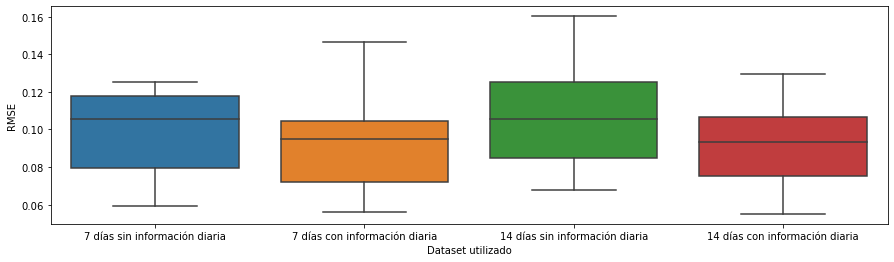

In [33]:
sns.boxplot(data=errores_training_rmse).set(xlabel='Dataset utilizado', ylabel='RMSE')

#### MAE

In [34]:
errores_training_mae = pd.concat([_7d_no_info_MAE, _7d_info_MAE, _14d_no_info_MAE, _14d_info_MAE], axis=1)
errores_training_mae

,7 días sin información diaria,7 días con información diaria,14 días sin información diaria,14 días con información diaria
Pliegues,,,,
Pliegue 1,0.085422,0.100721,0.116155,0.086717
Pliegue 2,0.059817,0.087314,0.050844,0.108209
Pliegue 3,0.049348,0.056445,0.047548,0.066055
Pliegue 4,0.089810,0.058134,0.090247,0.059203
Pliegue 5,0.052150,0.041371,0.073527,0.046487
Pliegue 6,0.032183,0.032657,0.038793,0.034587
Pliegue 7,0.042493,0.041599,0.054755,0.045747
Pliegue 8,0.076009,0.062027,0.070247,0.070769
Pliegue 9,0.069093,0.066239,0.067986,0.056273


In [35]:
errores_training_mae.to_csv("./CNN_mae_training.csv")

[Text(0.5, 0, 'Dataset utilizado'), Text(0, 0.5, 'MAE')]

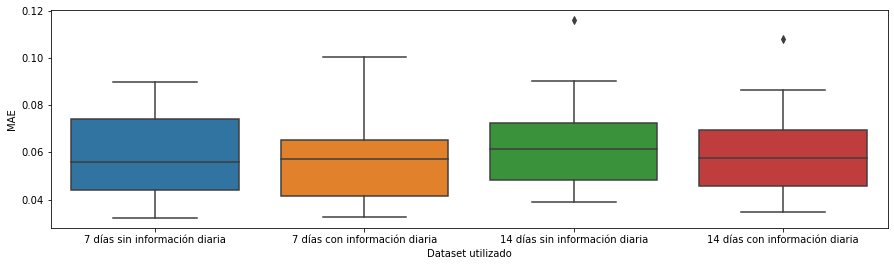

In [36]:
sns.boxplot(data=errores_training_mae).set(xlabel='Dataset utilizado', ylabel='MAE')

#### MAE

In [37]:
errores_training_mape = pd.concat([_7d_no_info_MAPE, _7d_info_MAPE, _14d_no_info_MAPE, _14d_info_MAPE], axis=1)
errores_training_mape

,7 días sin información diaria,7 días con información diaria,14 días sin información diaria,14 días con información diaria
Pliegues,,,,
Pliegue 1,26.154154,27.723329,27.832928,28.427078
Pliegue 2,56.330559,65.248286,46.105008,90.138683
Pliegue 3,30.836490,31.038896,27.346720,34.562833
Pliegue 4,31.086477,22.602800,32.360655,22.686976
Pliegue 5,20.666315,15.683449,23.666621,17.840995
Pliegue 6,49.786365,37.818197,63.461582,43.450277
Pliegue 7,39.280680,43.594028,46.962286,46.299219
Pliegue 8,15.983944,12.373584,16.482464,13.755855
Pliegue 9,34.499396,23.144803,33.069777,19.952993


In [38]:
errores_training_mape.to_csv("./CNN_mape_training.csv")

[Text(0.5, 0, 'Dataset utilizado'), Text(0, 0.5, 'MAPE')]

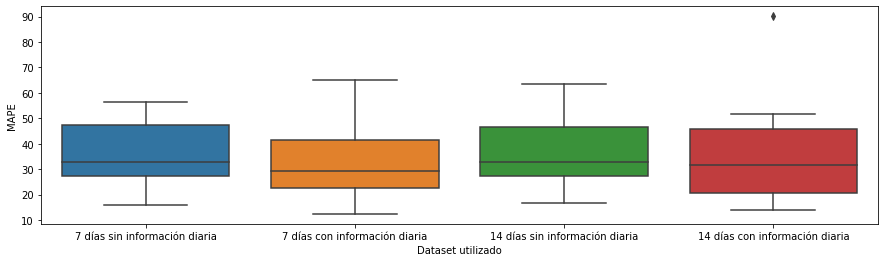

In [39]:
sns.boxplot(data=errores_training_mape).set(xlabel='Dataset utilizado', ylabel='MAPE')